In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

import healpy as hp
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db


In [2]:
plt.rc('legend', fontsize=20) # using a size in points
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rcParams['axes.labelsize'] = 16

In [3]:
# load opsim database
dbpath = "/home/idies/workspace/lsst_cadence/FBS_1.5/"  # path to all opsim databases

# output directory
outDir = '/home/idies/workspace/Temporary/lixl/scratch/outDir'
resultsDb = db.ResultsDb(outDir=outDir)



In [4]:
# get the name of all opsim dbs 
import glob

workpath = os.getcwd()
os.chdir(dbpath)  # change to opsim database directory
dblist_all = glob.glob('*.db') 
#workpath = '/home/idies/workspace/Storage/lixl/persistent/LSST_OpSim/unknowns/timeGaps/'
os.chdir(workpath) # change back to work directory
dblist_all.sort()



In [6]:
dblist_all[5:6]

['baseline_v1.5_10yrs.db']

In [5]:
def RADec2pix(nside, ra, dec, degree=True):
    """
    Calculate the nearest healpixel ID of an RA/Dec array, assuming nside.

    Parameters
    ----------
    nside : int
        The nside value of the healpix grid.
    ra : numpy.ndarray
        The RA values to be converted to healpix ids, in degree by default.
    dec : numpy.ndarray
        The Dec values to be converted to healpix ids, in degree by default.

    Returns
    -------
    numpy.ndarray
        The healpix ids.
    """
    if degree:
        ra = np.radians(ra) # change to radians
        dec = np.radians(dec)
    
    lat = np.pi/2. - dec
    hpid = hp.ang2pix(nside, lat, ra )
    return hpid

def pix2radec(nside, ipix, degree=True):
    """from ipix to ra/dec"""
    
    theta, phi = hp.pix2ang(nside, ipix)
    ra = phi
    dec = np.pi/2. - theta
    if degree:
        ra = np.rad2deg(ra)
        dec = np.rad2deg(dec)
    return ra, dec

In [6]:
from lsst.sims.maf.utils import m52snr

class filterPairTGapsMetric(metrics.BaseMetric):
    """
    returns
    N_v * np.exp(-Dkl) for each fields
    
    Parameters:
        colname: 
        fltpair: filter pair, eg ['r', 'i']
        snr_lim: list, signal to noise ratio (fiveSigmaDepth) threshold for fltpair, default [5, 5]
        filename: output a csv table for time gaps of each field
    
    """

    def __init__(self, colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'], fltpair=['r', 'i'], tmin=0, tmax=1.5/24, bins=50, mag_lim=[18, 18],
                 save_dT=False, filename=None, dataout=True, **kwargs):
        self.colname = colname
        self.filename = filename
        self.fltpair = fltpair
        self.mag_lim = mag_lim
        self.dataout = dataout
        self.tmin = tmin
        self.tmax = tmax
        self.bins = bins
        self.save_dT = save_dT
        
        self.Nrun = 0   # record the how many time run run()
        if filename!=None:
            if os.path.isfile(filename):
                # rm old file
                os.system("rm {}".format(filename))
                
        if self.dataout:
            super().__init__(col=self.colname, metricDtype='object', **kwargs)
        else:
            super().__init__(col=self.colname, metricDtype='float', **kwargs)
    
    def save_to_file(self, dic, filename="test_pkl.pkl"):
        '''save dict item to pickle file'''
        
        #df = self.load_from_pkl(filename)

        #df = df.append(pd.DataFrame(dic), ignore_index=True)

        #df.to_pickle(filename)
        df = pd.DataFrame(dic)
        with open(filename, 'a') as f:
            df.to_csv(f, header=f.tell()==0, index=None)
    
    def get_Dkl_i(self, values):
        '''kl divergence for histogram'''
        if values.any():
            values = values + 0.00001  # make each element non-zero
            prob = (values) / values.sum()  
        
            prob_uni = np.ones( len(prob) ) / len(prob)
            return np.sum( prob_uni * np.log(prob_uni / prob) )
        
        else:
            return np.NaN
        
    def get_FoM_i(self, dT_all, tmin=0, tmax=1.5/24, bins=50):
        """return FoM from array of metricValues"""
                
        dT_tlim = dT_all[(dT_all>tmin)&(dT_all<tmax)] 
        Nv = len(dT_tlim)
    
        values, bins_ = np.histogram(dT_tlim, bins=bins);
    
        Dkl = self.get_Dkl_i(values)
    
        FoM_i = Nv * np.exp(-Dkl)
        
        #print(self.Nrun, len(dT_all), Nv, Dkl, FoM_i)
        return Nv, Dkl, FoM_i, dT_tlim
      
    def run(self, dataSlice, slicePoint=None):
        
        # return all possible time gaps for each fields
        
        f0 = self.fltpair[0]
        f1 = self.fltpair[1]
        
        #check input config
        #print(f0, f1, self.tmin, self.tmax, self.mag_lim)
            
        # sort dataSlice
        
        idx0 = ( dataSlice['filter'] == f0 ) & ( dataSlice['fiveSigmaDepth'] > self.mag_lim[0])
        idx1 = ( dataSlice['filter'] == f1 ) & ( dataSlice['fiveSigmaDepth'] > self.mag_lim[1])
        
        timeCol0 = dataSlice['observationStartMJD'][idx0]
        timeCol1 = dataSlice['observationStartMJD'][idx1]

        timeCol0 = timeCol0.reshape((len(timeCol0), 1))
        timeCol1 = timeCol1.reshape((len(timeCol1), 1))
        
        #print( 'length of dataSlice', dataSlice.shape )
        # calculate time gaps matrix
        diffmat = np.abs( np.subtract(timeCol0, timeCol1.T) ) 
        
        # collect all time gaps
        if f0==f1:
            # get only triangle part
            dt_tri = np.tril(diffmat, -1)
            dT = dt_tri[dt_tri!=0]    # flatten lower triangle 
        else:
            dT = diffmat.flatten()

        Nv, Dkl, FoM_i, dT_tlim = self.get_FoM_i(dT, tmin=self.tmin, tmax=self.tmax, bins=self.bins)
        
        # print(self.Nrun, np.min(dataSlice['fiveSigmaDepth'][idx0]), np.min(dataSlice['fiveSigmaDepth'][idx1]),)
        self.Nrun += 1
        # write results to csv file
        fieldRA = np.mean(dataSlice['fieldRA']) ,
        fieldDec = np.mean(dataSlice['fieldDec']),
        
        if self.save_dT:
            dic = {'Nrun': self.Nrun, 
                'pixId': RADec2pix(nside=16, ra=fieldRA, dec=fieldDec)[0],
                'Nv': Nv,
                'Dkl': Dkl,
                'FoM_i': FoM_i,
                'dT_lim': dT_tlim
                  }
        else:
            dic = {'Nrun': self.Nrun, 
                'pixId': RADec2pix(nside=16, ra=fieldRA, dec=fieldDec)[0],
                'Nv': Nv,
                'Dkl': Dkl,
                'FoM_i': FoM_i,
                # 'dT_lim': dT_tlim
                  }
            
        if self.filename!=None:
            self.save_to_file(dic, filename=self.filename)
        
        if self.dataout:
            # return dT
            result = dic
            return result
        else:
        #    f0 = self.fltpair[0]
        #    f1 = self.fltpair[1]
            result = np.min(dT) if len(dT)!=0 else np.inf
            return float(result) 



In [7]:
def runMetric(dbname, fltpair, ipix_ms=None, nside=16, sqlstr=None,
              colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'],
              tmin=0, tmax=1.5/24, bins=50, mag_lim=[18, 18],
              filename=None, dataout=True, **kwargs
             ):
    """run filterPairTGapsMetric
    dbname: name of opsim database
    fltpair: filter pair, eg: 'ri'
    ipix_ms: pixIds of footprint
    """
    opsdb = db.OpsimDatabase(dbpath+dbname)
    
    #fltpair = ['r', 'i']
    
    if ipix_ms!=None:
        # use UserPointsSlicer for minisurvey
        ra, dec = pix2radec(nside=nside, ipix=ipix_ms)
        slicer = slicers.UserPointsSlicer(ra, dec, latLonDeg=True, badval=0)
    else:
        # use HealpixSlicer 
        slicer = slicers.HealpixSlicer(nside=nside)
    
    # metric, slicer, constraint
    metric = filterPairTGapsMetric( colname=colname, fltpair=fltpair, tmin=tmin, tmax=tmax, bins=bins, mag_lim=mag_lim,
                 filename=filename, dataout=dataout, **kwargs)
    
    sqlconstraint = 'filter in ("{}", "{}")'.format(*fltpair)
    if sqlstr!=None:
        sqlconstraint += ' and {}'.format(sqlstr)
        
    # bundle
    newMetricSky = metricBundles.MetricBundle(metric, slicer, sqlconstraint)
    
    # group bundle
    bundleDict = {'newMetricSky':newMetricSky}
    group = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir = outDir, resultsDb=resultsDb)
    
    # run
    group.runAll()
    #group.plotAll(closefigs = False)
    return newMetricSky



In [8]:
ipix_LMC = [2899, 2900, 2901, 2934, 2935, 2936, 2965, 2966, 2967, 2992, 2993, 2994]
ipix_SMC = [2960, 2961, 2988, 2989, 3012]
ipix_GP = [ 144,  145,  146,  147,  179,  180,  181,  182,  183,  184,  217,
        218,  219,  225,  226,  260,  261,  271,  272,  307,  308,  320,
        321,  358,  374,  413,  431,  432,  471,  472,  493,  534,  535,
        558,  598,  599,  622,  661,  662,  687,  725,  726,  751,  788,
        789,  790,  815,  816,  852,  853,  854,  879,  915,  916,  917,
        944,  979,  980,  981, 1008, 1042, 1043, 1044, 1045, 1073, 1107,
       1108, 1109, 1136, 1170, 1171, 1172, 1201, 1234, 1235, 1236, 1237,
       1265, 1297, 1298, 1299, 1300, 1330, 1361, 1362, 1363, 1364, 1393,
       1425, 1426, 1427, 1428, 1458, 1489, 1490, 1491, 1492, 1522, 1552,
       1553, 1554, 1555, 1587, 1616, 1617, 1618, 1619, 1620, 1650, 1679,
       1680, 1681, 1682, 1683, 1715, 1744, 1745, 1746, 1747, 1779, 1807,
       1808, 1809, 1810, 1811, 1843, 1871, 1872, 1873, 1874, 1875, 1907,
       1934, 1935, 1936, 1937, 1938, 1972, 1998, 1999, 2000, 2001, 2002,
       2003, 2036, 2062, 2063, 2064, 2065, 2066, 2100, 2126, 2127, 2128,
       2129, 2130, 2164, 2189, 2190, 2191, 2192, 2193, 2194, 2229, 2253,
       2254, 2255, 2256, 2257, 2258, 2293, 2316, 2317, 2318, 2319, 2320,
       2321, 2358, 2380, 2381, 2382, 2383, 2384, 2385, 2421, 2422, 2443,
       2444, 2445, 2446, 2447, 2448, 2449, 2486, 2487, 2507, 2508, 2509,
       2510, 2511, 2512, 2513, 2550, 2551, 2570, 2571, 2572, 2573, 2574,
       2575, 2576, 2614, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2673,
       2687, 2688, 2689, 2690, 2691, 2692, 2693, 2728, 2729, 2739, 2740,
       2741, 2742, 2743, 2744, 2745, 2746, 2779, 2780, 2781, 2787, 2788,
       2789, 2790, 2791, 2792, 2793, 2794, 2826, 2827, 2828, 2829, 2830,
       2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2869, 2870,
       2871, 2872, 2873, 2874, 2875, 2876, 2877, 2878, 2879, 2908, 2909,
       2910, 2911, 2912, 2913, 2914, 2915, 2916, 2943, 2944, 2945, 2946,
       2947, 2948, 2974, 2975, 2976]

In [9]:
df = pd.read_csv('./data/Fields_nside16.csv')
# LMC, SMC
df['inLMC'] = np.isin(df['pixId'].values, ipix_LMC)
df['inSMC'] = np.isin(df['pixId'].values, ipix_SMC)
df['inGP'] = np.isin(df['pixId'].values, ipix_GP)

df.head()

,pixId,fieldRa,fieldDec,fieldGl,fieldGb,fieldEl,fieldEb,starDensity_r25,TRIstarDensity_r25,inLMC,inSMC,inGP
0,0,45.0,87.075820,124.642960,24.641921,85.217963,64.413844,0,0,False,False,False
1,1,135.0,87.075820,125.753479,28.655621,94.800547,64.412987,0,0,False,False,False
2,2,225.0,87.075820,121.143387,29.592908,95.668530,68.533082,0,0,False,False,False
3,3,315.0,87.075820,120.187742,25.546039,84.354664,68.534126,0,0,False,False,False
4,4,22.5,84.149733,123.982115,21.356778,77.697559,63.791264,0,0,False,False,False


In [16]:
df_gp = df[ df['inGP'] ]

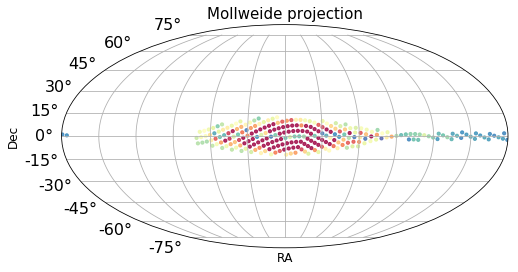

In [19]:
# plot footprint
fig, axs = plt.subplots(1, 1, figsize=(8, 8),
                            subplot_kw={'projection': 'mollweide'}); 

df = df_gp[df_gp.TRIstarDensity_r25!=0]

slicer = ( df['inLMC'] | df['inSMC'] | df['inGP'])
df_ = df[slicer]

#x = df_['fieldRa']
#y = df_['fieldDec']
x = df_['fieldGl']
y = df_['fieldGb']
#c = np.repeat(1.5, len(x))
c = df_['starDensity_r25']
plot_mwd(axs, RA=x, Dec=y, colorbar=False, c=c, s=10, alpha=0.8, vmax=1000000, cmap=plt.cm.Spectral_r)

axs.set_xticklabels([]);

### test run for one opsim

In [11]:
dblist_all[18]

'dcr_nham2_ugri_v1.5_10yrs.db'

In [31]:
ipix_ms = ipix_LMC 
#dbname = dblist_all[4] # baseline
dbname = dblist_all[0]
sqlstr = "proposalId=1"
# run one filter pair for baseline
metricSky = runMetric( dbname=dbname, fltpair=['u', 'r'], 
              ipix_ms=ipix_ms, nside=16, sqlstr=sqlstr,
              colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'],
              tmin=5/60/60/24, tmax=1.5/24, bins=np.linspace(5/60/60/24, 1.5/24, 50), mag_lim=[18, 18],
              filename=None, dataout=True, save_dT=True)


Querying database SummaryAllProps with constraint filter in ("u", "r") and proposalId=1 for columns ['fiveSigmaDepth', 'fieldDec', 'filter', 'fieldRA', 'observationStartMJD']
Found 523025 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [32]:
arr = metricSky.metricValues.data 
        
df = pd.DataFrame.from_records( arr[ arr != None ] )

In [33]:
df

,Dkl,FoM_i,Nrun,Nv,dT_lim,pixId
0,8.910185,0.000810,1,6,"[0.01579622815916082, 0.015862839922192506, 0....",2899
1,8.962838,0.000640,2,5,"[0.015831472679565195, 0.016106057970318943, 0...",2900
2,9.060603,0.000813,3,7,"[0.015848045572056435, 0.015841854095924646, 0...",2901


In [38]:
dbname

'agnddf_v1.5_10yrs.db'

In [39]:
data_df = get_cols(dbpath + dbname, cols='fieldRA, fieldDec, night, observationStartMJD, filter, fiveSigmaDepth')


connect to  /home/idies/workspace/lsst_cadence/FBS_1.5/agnddf_v1.5_10yrs.db 
 SELECT fieldRA, fieldDec, night, observationStartMJD, filter, fiveSigmaDepth FROM SummaryAllProps


In [40]:
data_df['pixId'] = RADec2pix(nside=16, ra=data_df.fieldRA.values, dec=data_df.fieldDec.values )


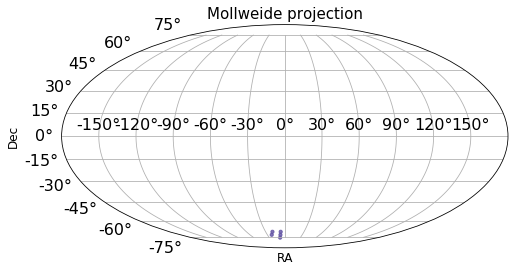

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8),
                            subplot_kw={'projection': 'mollweide'}); 

ra, dec = pix2radec(nside=16, ipix=ipix_SMC)
x = ra
y = dec
c = np.repeat(1.5, len(x))

plot_mwd(ax=ax, RA=x, Dec=y, colorbar=False, c=c, s=10, alpha=0.8, vmax=1000000, cmap=plt.cm.Spectral_r)




### run time gaps metrics

In [22]:
def get_Dkl(values):
    '''kl divergence for histogram'''
    if values.any():
        values = values + 0.00001  # make each element non-zero
        prob = (values) / values.sum()  
    
        prob_uni = np.ones( len(prob) ) / len(prob)
        return np.sum( prob_uni * np.log(prob_uni / prob) )
    
    else:
        return np.NaN

def get_FoM_tgaps(df, tmin=0, tmax=1.5/24, bins=50):
    """return FoM from array of metricValues
    Inputs:
     df: pd.DataFrame, cols ['pixId', 'Dkl', 'FoM_i', 'Nv', 'dT_lim']
    """
    
    dT_all = np.concatenate(df.dT_lim.values)
    
    dT_tlim = dT_all[(dT_all>tmin)&(dT_all<tmax)] 
    Nv = len(dT_tlim)

    values, bins_ = np.histogram(dT_tlim, bins=bins);

    Dkl = get_Dkl(values)

    FoM = Nv * np.exp(-Dkl)
    
    return FoM


In [23]:
fltpairs = ['uu', 'ug', 'ur', 'ui', 'uz', 'uy', 'gg', 'gr', 'gi', 'gz', 'gy',
           'rr', 'ri', 'rz', 'ry', 'ii', 'iz', 'iy', 'zz', 'zy', 'yy' ]

In [24]:
dblist_all[5:6 ]

['baseline_v1.5_10yrs.db']

In [40]:
%%time 
# run all filter pairs for baseline 

dicFoM = {}
dicFoM['db'] = dblist_all[5:6 ]

nside = 16
# select mini survey footprint 
msname = 'SMC' # minisurvey label used to save files

if msname == 'LMC':
    ipix_ms = ipix_LMC
elif msname=='SMC':
    ipix_ms = ipix_SMC

#sqlstr = "night<4000 and proposalId=1"
#sqlstr = None
sqlstr = "proposalId=1"
#sqlstr = "note not like '%DD%'"


magdic = {'u':18, 'g':18, 'r':18, 'i':18, 'z':18, 'y':18}

#--------------------------------
# empty metricArr 
diclist = []
for Nrun in range( len(ipix_ms) ):
    dic = {'Nrun': Nrun, 
                'pixId': ipix_ms[Nrun],
                'Nv': 0,
                'Dkl': 0,
                'FoM_i': 0,
                'dT_lim': []
                  }
    diclist.append(dic)
arr_empty = np.array(diclist)
df_empty = pd.DataFrame.from_records( arr_empty )
#--------------------------------

dataRaw = {}  # save the raw metricValues.data for each opsim each fltpair; dataRaw[fltpair][dbname]

for fltpair in fltpairs: 
    dicFoM[fltpair] = []
    dataRaw[fltpair] = {}
    for dbname in dicFoM['db']: 
        if fltpair[0]==fltpair[1]:
            tmin = 5/60/60/24 # in days
            tmax = 3e8/60./60./24    
            # histogram in log space
            bins=np.logspace(np.log10(tmin), np.log10(tmax), 50)
            
        else:
            tmin = 5/60/60/24
            #tmax = 1.5/24 # 1.5 hour in days
            tmax = 2  # 2 days
            bins = np.linspace(tmin, tmax, 50)
            
        metricSky = runMetric(dbname, fltpair=fltpair, sqlstr=sqlstr, nside=nside, ipix_ms=ipix_ms, 
                                 mag_lim=[magdic[fltpair[0]], magdic[fltpair[1]]],
                                 tmin=tmin, tmax=tmax, bins=bins,
                                 filename=None, save_dT=True, dataout=True );
            
        arr = metricSky.metricValues.data 
                
        df = pd.DataFrame.from_records( arr[ arr != None ] )
        
        if len(df)==0:
            df = df_empty
        
        
        FoM_tgaps = get_FoM_tgaps(df=df, tmin=tmin, tmax=tmax, bins=bins)

        dicFoM[fltpair].append(FoM_tgaps)
        
        #dataRaw[fltpair][dbname] = pd.DataFrame.from_records( arr[ arr != None ] )[['pixId', 'Dkl', 'FoM_i', 'Nv']]  
        
        # save the raw data, 
        dataRaw[fltpair][dbname] = df[['pixId', 'Dkl', 'FoM_i', 'Nv']]  
        
        print('>>>', fltpair, dbname, FoM_tgaps)
        
    df_fom = pd.DataFrame(dicFoM)
    #df_fom.to_csv('tgaps_FoM_baseline_v1.5_{}_inwfd.csv'.format(msname), index=False)
    # save raw data to pickle
    #pd.DataFrame( dataRaw ).to_pickle(outDir+'/tgaps_dataRaw_baseline_v1.5_{}_inwfd.pkl'.format(msname),)


Querying database SummaryAllProps with constraint filter in ("u", "u") and proposalId=1 for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 117746 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uu baseline_v1.5_10yrs.db nan
Querying database SummaryAllProps with constraint filter in ("u", "g") and proposalId=1 for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 290758 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ug baseline_v1.5_10yrs.db nan
Querying database SummaryAllProps with constraint filter in ("u", "r") and proposalId=1 for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 522979 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
C

In [39]:
msname = 'LMC'
df_dataRaw = pd.read_pickle( outDir+'/tgaps_dataRaw_baseline_v1.5_{}_inwfd.pkl'.format(msname) )


In [41]:
dataRaw['ur']['baseline_v1.5_10yrs.db']

,pixId,Dkl,FoM_i,Nv
0,2960,0,0,0
1,2961,0,0,0
2,2988,0,0,0
3,2989,0,0,0
4,3012,0,0,0


In [42]:
# get the median of N visits for each filter pair, 

Nvth = {}
for fltpair in fltpairs: 
    df = dataRaw[fltpair]['baseline_v1.5_10yrs.db']
    Nvth[fltpair] = np.median( df.Nv ) 
    

In [43]:
Nvth

{'uu': 0.0,
 'ug': 0.0,
 'ur': 0.0,
 'ui': 0.0,
 'uz': 0.0,
 'uy': 0.0,
 'gg': 0.0,
 'gr': 0.0,
 'gi': 0.0,
 'gz': 0.0,
 'gy': 0.0,
 'rr': 0.0,
 'ri': 0.0,
 'rz': 0.0,
 'ry': 0.0,
 'ii': 0.0,
 'iz': 0.0,
 'iy': 0.0,
 'zz': 0.0,
 'zy': 0.0,
 'yy': 0.0}

In [34]:
#starDens = np.load('./starDens16.npz')['starDens']
Fields = pd.read_csv("./data/Fields_nside16.csv")
starDens = Fields['starDensity_r25'].values
TRIstarDens = Fields['TRIstarDensity_r25'].values

In [47]:
%%time 

# run for all opsims all filter pairs

dicFoMtGaps = {}
dicNfields = {}
dicNstar = {}

dbnames = dblist_all
dicFoMtGaps['db'] = dbnames
dicNfields['db'] = dbnames
dicNstar['db'] = dbnames

nside = 16

# select mini survey footprint 
msname = 'SMC' # minisurvey label used to save files

if msname == 'LMC':
    ipix_ms = ipix_LMC
elif msname=='SMC':
    ipix = ipix_SMC
#sqlstr = "proposalId=1"

sqlstr = "note not like '%DD%'" 

magdic = {'u':18, 'g':18, 'r':18, 'i':18, 'z':18, 'y':18}

#--------------------------------
# empty metricArr 
diclist = []
for Nrun in range( len(ipix_ms) ):
    dic = {'Nrun': Nrun, 
                'pixId': ipix_ms[Nrun],
                'Nv': 0,
                'Dkl': 0,
                'FoM_i': 0,
                'dT_lim': []
                  }
    diclist.append(dic)
arr_empty = np.array(diclist)
df_empty = pd.DataFrame.from_records( arr_empty )
#--------------------------------

dataRaw = {}  # save the raw metricValues.data for each opsim each fltpair; dataRaw[fltpair][dbname]
for fltpair in fltpairs:  
    
    dicFoMtGaps[fltpair] = []
    dicNfields[fltpair] = []
    dicNstar[fltpair] = []
    
    dataRaw[fltpair] = {}
    for dbname in dbnames: 

        print('running ', dbname, fltpair)
        if fltpair[0]==fltpair[1]:
            tmin = 5/60/60/24 # in days
            tmax = 3e8/60./60./24    
            # histogram in log space
            bins=np.logspace(np.log10(tmin), np.log10(tmax), 50)
            
        else:
            tmin = 5/60/60/24
            #tmax = 1.5/24 # 1.5 hour in days
            tmax = 2
            bins = np.linspace(tmin, tmax, 50)
            
        metricSky = runMetric(dbname, fltpair=fltpair, sqlstr=sqlstr, nside=nside, ipix_ms=ipix_ms, 
                                 mag_lim=[magdic[fltpair[0]], magdic[fltpair[1]]],
                                 tmin=tmin, tmax=tmax, bins=bins,
                                 filename=None, save_dT=True, dataout=True );
            
        arr = metricSky.metricValues.data 
        
        df = pd.DataFrame.from_records( arr[ arr != None ] )
        if len(df)==0:
            df = df_empty
        # count number of fields/stars above threshold 
        df['starDensity'] = starDens[ df['pixId'].values ] 
        idx = df['Nv'] > Nvth[fltpair]
        Nfields = df['Nv'][idx].shape[0]
        Nstar = np.sum( df['starDensity'][idx] )

        FoM_tgaps = get_FoM_tgaps(df=df, tmin=tmin, tmax=tmax, bins=bins)
                
        dicFoMtGaps[fltpair].append (FoM_tgaps)
        dicNfields[fltpair].append(Nfields)
        dicNstar[fltpair].append(Nstar)
        
        # save the raw data, 
        dataRaw[fltpair][dbname] = df[['pixId', 'Dkl', 'FoM_i', 'Nv']]  
        
        print('>>>', fltpair, dbname, FoM_tgaps, Nfields, Nstar)
    
    df_fom = pd.DataFrame(dicFoMtGaps)
    df_fom.to_csv('data_v1_5/df_tgapsFoM_{}_all_2d.csv'.format(msname), index=False)
    
    df_fom = pd.DataFrame(dicNfields)
    df_fom.to_csv('data_v1_5/df_Nfields_{}_all_2d.csv'.format(msname), index=False)
    
    df_fom = pd.DataFrame(dicNstar)
    df_fom.to_csv('data_v1_5/df_Nstar_{}_all_2d.csv'.format(msname), index=False)
    
    # save raw data to pickle
    pd.DataFrame( dataRaw ).to_pickle(outDir+'/dataRaw_v1_5/tgaps_dataRaw_{}_all_2d.pkl'.format(msname),)



running  agnddf_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 137990 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uu agnddf_v1.5_10yrs.db 1.8549361961088189 5 65556
running  alt_dust_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 137491 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uu alt_dust_v1.5_10yrs.db 8.30207250939793 5 65556
running  alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fiveSigmaDepth

Found 135186 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uu descddf_v1.5_10yrs.db 1.2867441415001826 5 65556
running  filterdist_indx1_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 347457 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uu filterdist_indx1_v1.5_10yrs.db nan 0 0
running  filterdist_indx2_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 144750 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uu filterdist_indx2_v1.5_

Found 132608 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uu footprint_stuck_rollingv1.5_10yrs.db 1.1373037752136763 5 65556
running  goodseeing_gi_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 135361 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uu goodseeing_gi_v1.5_10yrs.db 1.2561826946868428 5 65556
running  goodseeing_gri_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 137087 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>

Found 135359 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uu third_obs_pt120v1.5_10yrs.db 0.5791296366937795 5 65556
running  third_obs_pt15v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 135826 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uu third_obs_pt15v1.5_10yrs.db 1.3451040688009646 5 65556
running  third_obs_pt30v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 136021 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uu third

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uu wfd_depth_scale0.80_v1.5_10yrs.db 6.263334517868371 5 65556
running  wfd_depth_scale0.85_noddf_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 143339 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uu wfd_depth_scale0.85_noddf_v1.5_10yrs.db 11.490820160450498 5 65556
running  wfd_depth_scale0.85_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 136779 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uu wfd_depth_scale0.8

Found 348378 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ug bulges_cadence_i_heavy_v1.5_10yrs.db 0.02816556737792525 5 65556
running  bulges_i_heavy_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 347605 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ug bulges_i_heavy_v1.5_10yrs.db 0.11803540076189417 5 65556
running  daily_ddf_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 333119 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> 

Found 349045 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ug footprint_big_sky_nouiyv1.5_10yrs.db 0.015503913345400052 4 50400
running  footprint_big_skyv1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 339984 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ug footprint_big_skyv1.5_10yrs.db 0.03997932433003175 4 50400
running  footprint_big_wfdv1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 352556 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Com

Found 352888 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ug rolling_mod3_sdf_0.10_v1.5_10yrs.db 0.007497246024234244 5 65556
running  rolling_mod3_sdf_0.20_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 354953 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ug rolling_mod3_sdf_0.20_v1.5_10yrs.db 0.0055555619474194325 5 65556
running  rolling_mod6_sdf_0.10_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 348739 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary

Found 278692 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ug u60_v1.5_10yrs.db 0.0064577251703564825 5 65556
running  var_expt_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 334841 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ug var_expt_v1.5_10yrs.db 0.009294837204699265 5 65556
running  wfd_depth_scale0.65_noddf_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 385374 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ug wfd_depth

Found 600897 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ur alt_dust_v1.5_10yrs.db 0.07288084430539496 5 65556
running  alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 599038 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ur alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db 0.04570681811266675 5 65556
running  baseline_2snaps_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 557839 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistic

Found 631051 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ur filterdist_indx2_v1.5_10yrs.db nan 0 0
running  filterdist_indx3_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 578806 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ur filterdist_indx3_v1.5_10yrs.db nan 0 0
running  filterdist_indx4_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 786477 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ur filterdist_indx4_v1.5_10yrs.db n

Found 605078 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ur goodseeing_gri_v1.5_10yrs.db 0.01969363209898355 5 65556
running  goodseeing_griz_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 603543 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ur goodseeing_griz_v1.5_10yrs.db 0.004596943860595869 5 65556
running  goodseeing_gz_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 603315 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> u

Found 604168 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ur third_obs_pt30v1.5_10yrs.db 0.004205324217515627 5 65556
running  third_obs_pt45v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 603638 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ur third_obs_pt45v1.5_10yrs.db 0.00743088758173566 5 65556
running  third_obs_pt60v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 604356 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ur thi

Found 607178 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ur wfd_depth_scale0.85_v1.5_10yrs.db 0.01991024711836973 5 65556
running  wfd_depth_scale0.90_noddf_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 633934 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ur wfd_depth_scale0.90_noddf_v1.5_10yrs.db 0.012263449487566098 5 65556
running  wfd_depth_scale0.90_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 603039 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summa

Found 579696 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ui daily_ddf_v1.5_10yrs.db 0.003060185224863707 5 65556
running  dcr_nham1_ug_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 609271 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ui dcr_nham1_ug_v1.5_10yrs.db 0.007956765218840988 5 65556
running  dcr_nham1_ugr_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 608751 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ui dcr_nham

Found 609687 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ui footprint_big_wfdv1.5_10yrs.db 0.0017659966212348276 4 53064
running  footprint_bluer_footprintv1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 598236 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ui footprint_bluer_footprintv1.5_10yrs.db 0.0017066656007827783 5 65556
running  footprint_gp_smoothv1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 607079 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary 

Found 604992 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ui rolling_mod6_sdf_0.10_v1.5_10yrs.db 0.005935218272355813 5 65556
running  rolling_mod6_sdf_0.20_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 605721 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ui rolling_mod6_sdf_0.20_v1.5_10yrs.db 0.006559589516764172 5 65556
running  short_exp_2ns_1expt_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 696674 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary st

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ui wfd_depth_scale0.65_noddf_v1.5_10yrs.db 0.017957787961445187 5 65556
running  wfd_depth_scale0.65_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 622210 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ui wfd_depth_scale0.65_v1.5_10yrs.db 0.0064609942248608655 5 65556
running  wfd_depth_scale0.70_noddf_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 649883 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ui wfd_depth_sc

Found 515569 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uz baseline_2snaps_v1.5_10yrs.db 0.0010369614564798009 3 41328
running  baseline_samefilt_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 604328 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uz baseline_samefilt_v1.5_10yrs.db nan 0 0
running  baseline_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 557518 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uz baseline_v1.5_10y

Found 748380 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uz filterdist_indx4_v1.5_10yrs.db nan 0 0
running  filterdist_indx5_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 693519 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uz filterdist_indx5_v1.5_10yrs.db nan 0 0
running  filterdist_indx6_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 529911 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uz filterdist_indx6_v1.5_10yrs.db n

Found 558094 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uz goodseeing_gz_v1.5_10yrs.db 0.001043083653555958 5 65556
running  goodseeing_i_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 555848 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uz goodseeing_i_v1.5_10yrs.db 0.0010819494514405265 4 50400
running  greedy_footprint_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 550038 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uz 

Found 557462 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uz third_obs_pt60v1.5_10yrs.db 0.0006374860113640337 2 28908
running  third_obs_pt90v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 559669 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uz third_obs_pt90v1.5_10yrs.db 0.0006448421365346356 5 65556
running  twilight_neo_mod1_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 813557 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>

Found 557099 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uz wfd_depth_scale0.90_v1.5_10yrs.db 0.0010868907462500937 5 65556
running  wfd_depth_scale0.95_noddf_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 579157 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uz wfd_depth_scale0.95_noddf_v1.5_10yrs.db 0.0006428091986966666 3 41328
running  wfd_depth_scale0.95_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 552739 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running su

Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 552527 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uy dcr_nham1_ugri_v1.5_10yrs.db 0.0006194756396805537 1 12492
running  dcr_nham2_ug_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 557289 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uy dcr_nham2_ug_v1.5_10yrs.db nan 0 0
running  dcr_nham2_ugr_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observat

Found 579918 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uy footprint_newAv1.5_10yrs.db 0.0006284547612558839 2 24228
running  footprint_newBv1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 583985 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uy footprint_newBv1.5_10yrs.db 0.0007949693521516017 2 27648
running  footprint_no_gp_northv1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 549610 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uy short_exp_2ns_5expt_v1.5_10yrs.db nan 0 0
running  short_exp_5ns_1expt_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 721499 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uy short_exp_5ns_1expt_v1.5_10yrs.db 0.0006466074671305151 2 24228
running  short_exp_5ns_5expt_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 701381 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uy short_exp_5ns_5expt_v1.5_10yrs.db nan 0 0
run

Found 542285 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uy wfd_depth_scale0.75_noddf_v1.5_10yrs.db nan 0 0
running  wfd_depth_scale0.75_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 518404 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uy wfd_depth_scale0.75_v1.5_10yrs.db 0.0008178482356647346 3 37908
running  wfd_depth_scale0.80_noddf_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 553487 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Comp

Found 214966 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gg bulges_cadence_bs_v1.5_10yrs.db 7.154154937150337 5 65556
running  bulges_cadence_bulge_wfd_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 215511 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gg bulges_cadence_bulge_wfd_v1.5_10yrs.db 12.746269520000125 5 65556
running  bulges_cadence_i_heavy_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 214085 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary st

Found 210879 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gg footprint_add_mag_cloudsv1.5_10yrs.db 29.19348167788482 5 65556
running  footprint_big_sky_dustv1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 202779 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gg footprint_big_sky_dustv1.5_10yrs.db 4.494715443884826 4 50400
running  footprint_big_sky_nouiyv1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 218871 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary sta

Found 217101 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gg rolling_mod2_sdf_0.10_v1.5_10yrs.db 2.4356799608436703 5 65556
running  rolling_mod2_sdf_0.20_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 217193 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gg rolling_mod2_sdf_0.20_v1.5_10yrs.db 0.7084507673900606 5 65556
running  rolling_mod3_sdf_0.10_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 216097 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary stat

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gg twilight_neo_mod3_v1.5_10yrs.db 1.5404594382741186 5 65556
running  twilight_neo_mod4_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 220614 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gg twilight_neo_mod4_v1.5_10yrs.db 2.5254342576846462 5 65556
running  u60_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 202349 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gg u60_v1.5_10yrs.db 2.2085861001117206 5 65556
runnin

Found 201577 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gg wfd_depth_scale0.99_v1.5_10yrs.db 0.15900770140350518 5 65556
running  agnddf_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 675599 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gr agnddf_v1.5_10yrs.db 0.014686273211936477 5 65556
running  alt_dust_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 680178 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gr alt_dust_v1.5_10

Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 670607 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gr descddf_v1.5_10yrs.db 0.008799787151015738 5 65556
running  filterdist_indx1_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 734888 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gr filterdist_indx1_v1.5_10yrs.db nan 0 0
running  filterdist_indx2_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'obser

Found 679418 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gr footprint_standard_goalsv1.5_10yrs.db 0.011425506012975038 5 65556
running  footprint_stuck_rollingv1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 679706 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gr footprint_stuck_rollingv1.5_10yrs.db 0.004530971267743131 5 65556
running  goodseeing_gi_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 680057 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary stat

Found 680248 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gr spiders_v1.5_10yrs.db 0.009912504681401623 5 65556
running  third_obs_pt120v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 683779 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gr third_obs_pt120v1.5_10yrs.db 0.004434431085563596 5 65556
running  third_obs_pt15v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 679397 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gr third_

Found 725952 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gr wfd_depth_scale0.80_noddf_v1.5_10yrs.db 0.03861639947302686 5 65556
running  wfd_depth_scale0.80_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 690102 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gr wfd_depth_scale0.80_v1.5_10yrs.db 0.012903135647568226 5 65556
running  wfd_depth_scale0.85_noddf_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 719178 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summa

Found 689100 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gi bulges_cadence_bulge_wfd_v1.5_10yrs.db 0.03160046844902666 5 65556
running  bulges_cadence_i_heavy_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 695514 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gi bulges_cadence_i_heavy_v1.5_10yrs.db 0.06905479776193334 5 65556
running  bulges_i_heavy_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 695925 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary stat

Found 664761 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gi footprint_big_sky_dustv1.5_10yrs.db 0.054925520845628684 4 50400
running  footprint_big_sky_nouiyv1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 665495 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gi footprint_big_sky_nouiyv1.5_10yrs.db 0.11507036319765337 4 50400
running  footprint_big_skyv1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 692640 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary stat

Found 686980 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gi rolling_mod2_sdf_0.20_v1.5_10yrs.db 0.0036850310775217695 5 65556
running  rolling_mod3_sdf_0.10_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 687294 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gi rolling_mod3_sdf_0.10_v1.5_10yrs.db 0.008333093000356735 5 65556
running  rolling_mod3_sdf_0.20_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 688355 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary

Found 753680 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gi twilight_neo_mod4_v1.5_10yrs.db 0.0022781494359150737 5 65556
running  u60_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 658186 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gi u60_v1.5_10yrs.db 0.002194158849863778 5 65556
running  var_expt_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 650519 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gi var_expt_v1.5_10yrs.db

Found 626939 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gz agnddf_v1.5_10yrs.db 0.00100556239127528 3 39384
running  alt_dust_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 640306 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gz alt_dust_v1.5_10yrs.db 0.0063802634794187406 5 65556
running  alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 646108 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gz alt_r

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gz descddf_v1.5_10yrs.db 0.0008016075546647241 3 39312
running  filterdist_indx1_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 742411 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gz filterdist_indx1_v1.5_10yrs.db nan 0 0
running  filterdist_indx2_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 647436 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gz filterdist_indx2_v1.5_10yrs.db nan 0 0
running  filterdist_indx3_v

Found 634714 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gz footprint_stuck_rollingv1.5_10yrs.db 0.001066744832533574 4 53820
running  goodseeing_gi_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 632590 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gz goodseeing_gi_v1.5_10yrs.db 0.0037627056287649393 5 65556
running  goodseeing_gri_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 631942 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed

Found 638649 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gz third_obs_pt120v1.5_10yrs.db 0.003793959186285072 5 65556
running  third_obs_pt15v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 633446 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gz third_obs_pt15v1.5_10yrs.db 0.0017849490655457332 5 65556
running  third_obs_pt30v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 633213 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gz 

Found 644527 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gz wfd_depth_scale0.80_v1.5_10yrs.db 0.0021586698778089507 5 65556
running  wfd_depth_scale0.85_noddf_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 668538 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gz wfd_depth_scale0.85_noddf_v1.5_10yrs.db 0.002997032279893528 5 65556
running  wfd_depth_scale0.85_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 638178 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running sum

Found 628186 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gy bulges_cadence_i_heavy_v1.5_10yrs.db 0.0029787206601402105 4 53136
running  bulges_i_heavy_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 628302 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gy bulges_i_heavy_v1.5_10yrs.db 0.0017268110925619587 4 51804
running  daily_ddf_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 596520 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Found 636218 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gy footprint_big_sky_nouiyv1.5_10yrs.db 0.0006284547612558839 2 24156
running  footprint_big_skyv1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 621041 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gy footprint_big_skyv1.5_10yrs.db 0.0008063474247940545 1 11736
running  footprint_big_wfdv1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 643064 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.


Found 636190 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gy rolling_mod3_sdf_0.10_v1.5_10yrs.db 0.0014842339382334557 3 37980
running  rolling_mod3_sdf_0.20_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 636294 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gy rolling_mod3_sdf_0.20_v1.5_10yrs.db nan 0 0
running  rolling_mod6_sdf_0.10_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 645547 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Complete

Found 591201 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gy var_expt_v1.5_10yrs.db 0.0008215907450633113 4 53064
running  wfd_depth_scale0.65_noddf_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 618267 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> gy wfd_depth_scale0.65_noddf_v1.5_10yrs.db 0.0046498518160223365 4 53820
running  wfd_depth_scale0.65_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 589694 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary stati

Found 459438 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> rr alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db 340.2302814873521 5 65556
running  baseline_2snaps_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 431746 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> rr baseline_2snaps_v1.5_10yrs.db 3.513206909250678 5 65556
running  baseline_samefilt_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 481496 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Comp

Found 441198 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> rr filterdist_indx3_v1.5_10yrs.db nan 0 0
running  filterdist_indx4_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 435207 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> rr filterdist_indx4_v1.5_10yrs.db nan 0 0
running  filterdist_indx5_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 386481 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> rr filterdist_indx5_v1.5_10yrs.db n

Found 467373 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> rr goodseeing_griz_v1.5_10yrs.db 4.572730977109723 5 65556
running  goodseeing_gz_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 467322 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> rr goodseeing_gz_v1.5_10yrs.db 5.986699456042446 5 65556
running  goodseeing_i_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 467512 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> rr goodsee

Found 468029 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> rr third_obs_pt45v1.5_10yrs.db 1.9568570504434393 5 65556
running  third_obs_pt60v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 468976 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> rr third_obs_pt60v1.5_10yrs.db 4.02955253600582 5 65556
running  third_obs_pt90v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 470200 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> rr third_ob

Found 491369 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> rr wfd_depth_scale0.90_noddf_v1.5_10yrs.db 4.546525930506402 5 65556
running  wfd_depth_scale0.90_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 467393 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> rr wfd_depth_scale0.90_v1.5_10yrs.db 1.5059186648138108 5 65556
running  wfd_depth_scale0.95_noddf_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 489513 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary s

Found 936949 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ri dcr_nham1_ug_v1.5_10yrs.db 0.005178238524449324 5 65556
running  dcr_nham1_ugr_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 936623 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ri dcr_nham1_ugr_v1.5_10yrs.db 0.0041535531500433535 5 65556
running  dcr_nham1_ugri_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 937336 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ri d

Found 927816 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ri footprint_bluer_footprintv1.5_10yrs.db 0.004153071850470875 5 65556
running  footprint_gp_smoothv1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 941081 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ri footprint_gp_smoothv1.5_10yrs.db 0.004181687861365421 5 65556
running  footprint_newAv1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 937483 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.

Found 932669 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ri rolling_mod6_sdf_0.20_v1.5_10yrs.db 0.009272017155864946 5 65556
running  short_exp_2ns_1expt_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 1070973 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ri short_exp_2ns_1expt_v1.5_10yrs.db 0.002668140380299587 5 65556
running  short_exp_2ns_5expt_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 1055185 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary stat

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ri wfd_depth_scale0.65_v1.5_10yrs.db 0.019372604479851993 5 65556
running  wfd_depth_scale0.70_noddf_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 1006776 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ri wfd_depth_scale0.70_noddf_v1.5_10yrs.db 0.14905826037749137 5 65556
running  wfd_depth_scale0.70_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 957584 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ri wfd_depth_sca

Found 922139 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> rz baseline_samefilt_v1.5_10yrs.db 0.0017849469528001248 3 41328
running  baseline_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 889335 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> rz baseline_v1.5_10yrs.db 0.0023412014519383307 5 65556
running  bulges_bs_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 887606 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> rz bulges_bs_

Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 958990 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> rz filterdist_indx5_v1.5_10yrs.db nan 0 0
running  filterdist_indx6_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 841480 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> rz filterdist_indx6_v1.5_10yrs.db nan 0 0
running  filterdist_indx7_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartM

Found 889423 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> rz goodseeing_gz_v1.5_10yrs.db 0.008357544317686408 5 65556
running  goodseeing_i_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 888726 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> rz goodseeing_i_v1.5_10yrs.db 0.0030601774220203387 5 65556
running  greedy_footprint_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 879121 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> rz 

Found 891058 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> rz third_obs_pt60v1.5_10yrs.db 0.001730961327719272 4 53820
running  third_obs_pt90v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 894045 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> rz third_obs_pt90v1.5_10yrs.db 0.002342186866025764 5 65556
running  twilight_neo_mod1_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 1404190 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> 

Found 888846 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> rz wfd_depth_scale0.90_v1.5_10yrs.db 0.0014206861691243085 5 65556
running  wfd_depth_scale0.95_noddf_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 928387 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> rz wfd_depth_scale0.95_noddf_v1.5_10yrs.db 0.0014428235629685465 5 65556
running  wfd_depth_scale0.95_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 885723 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running su

Found 880306 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ry dcr_nham1_ugr_v1.5_10yrs.db 0.0013084688775893097 3 39312
running  dcr_nham1_ugri_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 879055 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ry dcr_nham1_ugri_v1.5_10yrs.db 0.0017911442637680833 5 65556
running  dcr_nham2_ug_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 876496 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ry

Found 884542 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ry footprint_gp_smoothv1.5_10yrs.db 0.0008130702193885812 2 24228
running  footprint_newAv1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 897083 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ry footprint_newAv1.5_10yrs.db 0.04168415048476925 5 65556
running  footprint_newBv1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 897765 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> 

Found 1001872 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ry short_exp_2ns_1expt_v1.5_10yrs.db 0.0011038394847548184 1 12420
running  short_exp_2ns_5expt_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 987132 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ry short_exp_2ns_5expt_v1.5_10yrs.db 0.0010947364272515683 2 26172
running  short_exp_5ns_1expt_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 1142951 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary stat

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ry wfd_depth_scale0.70_noddf_v1.5_10yrs.db 0.009989508295185611 5 65556
running  wfd_depth_scale0.70_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 847731 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ry wfd_depth_scale0.70_v1.5_10yrs.db 0.0022803296557735403 5 65556
running  wfd_depth_scale0.75_noddf_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 897435 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ry wfd_depth_sc

Found 471731 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ii baseline_v1.5_10yrs.db 2.238498409188679 5 65556
running  bulges_bs_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 473693 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ii bulges_bs_v1.5_10yrs.db 90.20888874622426 5 65556
running  bulges_bulge_wfd_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 473590 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ii bulges_bulge_wfd_v

Found 657315 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ii filterdist_indx6_v1.5_10yrs.db nan 0 0
running  filterdist_indx7_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 452592 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ii filterdist_indx7_v1.5_10yrs.db nan 0 0
running  filterdist_indx8_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 484402 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ii filterdist_indx8_v1.5_10yrs.db n

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ii goodseeing_i_v1.5_10yrs.db 5.611430327493203 5 65556
running  greedy_footprint_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 477908 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ii greedy_footprint_v1.5_10yrs.db 2.902940574422375 5 65556
running  roll_mod2_dust_sdf_0.20_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 467765 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ii roll_mod2_dust_sdf_0.20_v1.5_10yrs.db 21

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ii third_obs_pt90v1.5_10yrs.db 2.774422911560419 5 65556
running  twilight_neo_mod1_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 729726 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ii twilight_neo_mod1_v1.5_10yrs.db 1.6044585409111527 5 65556
running  twilight_neo_mod2_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 595658 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ii twilight_neo_mod2_v1.5_10yrs.db 4.09350755

Found 494117 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ii wfd_depth_scale0.95_noddf_v1.5_10yrs.db 0.7287887346574804 5 65556
running  wfd_depth_scale0.95_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 470825 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ii wfd_depth_scale0.95_v1.5_10yrs.db 0.33683540783998206 5 65556
running  wfd_depth_scale0.99_noddf_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 493011 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> iz dcr_nham1_ugri_v1.5_10yrs.db 0.006413808824255435 5 65556
running  dcr_nham2_ug_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 887591 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> iz dcr_nham2_ug_v1.5_10yrs.db 0.007596195453246247 5 65556
running  dcr_nham2_ugr_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 886640 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> iz dcr_nham2_ugr_v1.5_10yrs.db 0.004539540380247517 5

Found 869381 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> iz footprint_newAv1.5_10yrs.db 0.05957131955816254 5 65556
running  footprint_newBv1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 867877 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> iz footprint_newBv1.5_10yrs.db 0.1358188550331567 5 65556
running  footprint_no_gp_northv1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 893840 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> i

Found 1003049 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> iz short_exp_2ns_5expt_v1.5_10yrs.db 0.006376432985660374 5 65556
running  short_exp_5ns_1expt_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 1164564 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> iz short_exp_5ns_1expt_v1.5_10yrs.db 0.002361135807563308 5 65556
running  short_exp_5ns_5expt_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 1129979 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary stati

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> iz wfd_depth_scale0.70_v1.5_10yrs.db 0.017748853396680826 5 65556
running  wfd_depth_scale0.75_noddf_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 951969 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> iz wfd_depth_scale0.75_noddf_v1.5_10yrs.db 0.011126502210940987 5 65556
running  wfd_depth_scale0.75_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 907999 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> iz wfd_depth_sca

Found 890096 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> iy bulges_bs_v1.5_10yrs.db 0.41237147670543417 5 65556
running  bulges_bulge_wfd_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 890029 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> iy bulges_bulge_wfd_v1.5_10yrs.db 0.15022604252252733 5 65556
running  bulges_cadence_bs_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 890090 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> i

Found 879915 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> iy filterdist_indx7_v1.5_10yrs.db nan 0 0
running  filterdist_indx8_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 984989 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> iy filterdist_indx8_v1.5_10yrs.db nan 0 0
running  footprint_add_mag_cloudsv1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 886647 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> iy footprint_add_mag_cloudsv

Found 892535 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> iy greedy_footprint_v1.5_10yrs.db 0.016932392394019728 5 65556
running  roll_mod2_dust_sdf_0.20_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 887449 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> iy roll_mod2_dust_sdf_0.20_v1.5_10yrs.db 0.1841239494591068 5 65556
running  rolling_mod2_sdf_0.10_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 885972 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary sta

Found 1258017 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> iy twilight_neo_mod1_v1.5_10yrs.db 0.016620188909783302 5 65556
running  twilight_neo_mod2_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 1072473 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> iy twilight_neo_mod2_v1.5_10yrs.db 0.012322553405472059 5 65556
running  twilight_neo_mod3_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 1011885 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
C

Found 895727 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> iy wfd_depth_scale0.95_v1.5_10yrs.db 0.0032040766842998127 5 65556
running  wfd_depth_scale0.99_noddf_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 947586 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> iy wfd_depth_scale0.99_noddf_v1.5_10yrs.db 0.0018748648759304531 5 65556
running  wfd_depth_scale0.99_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 903958 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running su

Found 418979 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> zz dcr_nham2_ugr_v1.5_10yrs.db 2.415189298036069 5 65556
running  dcr_nham2_ugri_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 416902 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> zz dcr_nham2_ugri_v1.5_10yrs.db 1.3824564560469084 5 65556
running  descddf_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 413781 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> zz descddf_v1.

Found 421624 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> zz footprint_no_gp_northv1.5_10yrs.db 7.988162811021197 5 65556
running  footprint_standard_goalsv1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 421239 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> zz footprint_standard_goalsv1.5_10yrs.db 2.523014943566687 5 65556
running  footprint_stuck_rollingv1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 422832 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary st

Found 532497 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> zz short_exp_5ns_5expt_v1.5_10yrs.db 3.4100227213816123 5 65556
running  spiders_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 422869 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> zz spiders_v1.5_10yrs.db 3.52593605489884 5 65556
running  third_obs_pt120v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 425878 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> zz third_obs_pt1

Found 447429 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> zz wfd_depth_scale0.80_noddf_v1.5_10yrs.db 35.37535368024597 5 65556
running  wfd_depth_scale0.80_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 427493 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> zz wfd_depth_scale0.80_v1.5_10yrs.db 13.311195689645505 5 65556
running  wfd_depth_scale0.85_noddf_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 444154 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary s

Found 839507 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> zy bulges_cadence_bulge_wfd_v1.5_10yrs.db 0.13057119210995743 5 65556
running  bulges_cadence_i_heavy_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 834388 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> zy bulges_cadence_i_heavy_v1.5_10yrs.db 0.08642890780381429 5 65556
running  bulges_i_heavy_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 834899 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary stat

Found 858630 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> zy footprint_big_sky_dustv1.5_10yrs.db 0.33603611729665295 4 50400
running  footprint_big_sky_nouiyv1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 853751 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> zy footprint_big_sky_nouiyv1.5_10yrs.db 0.2792736207621997 4 50400
running  footprint_big_skyv1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 837486 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statis

Found 837024 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> zy rolling_mod2_sdf_0.20_v1.5_10yrs.db 0.03059880933808374 5 65556
running  rolling_mod3_sdf_0.10_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 842183 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> zy rolling_mod3_sdf_0.10_v1.5_10yrs.db 0.026353362777642494 5 65556
running  rolling_mod3_sdf_0.20_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 840435 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary s

Found 925525 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> zy twilight_neo_mod4_v1.5_10yrs.db 0.01481933408775453 5 65556
running  u60_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 812077 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> zy u60_v1.5_10yrs.db 0.023379280963453184 5 65556
running  var_expt_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 778701 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> zy var_expt_v1.5_10yrs.db 0

Found 409167 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> yy agnddf_v1.5_10yrs.db 17.965420346411978 5 65556
running  alt_dust_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 417930 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> yy alt_dust_v1.5_10yrs.db 167.8627544350797 5 65556
running  alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 420227 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> yy alt_roll_m

Found 392237 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> yy filterdist_indx1_v1.5_10yrs.db nan 0 0
running  filterdist_indx2_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 456565 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> yy filterdist_indx2_v1.5_10yrs.db nan 0 0
running  filterdist_indx3_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 407489 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> yy filterdist_indx3_v1.5_10yrs.db n

Found 412828 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> yy goodseeing_gi_v1.5_10yrs.db 14.267788094628866 5 65556
running  goodseeing_gri_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 412024 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> yy goodseeing_gri_v1.5_10yrs.db 7.1589382293267105 5 65556
running  goodseeing_griz_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 412154 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> yy go

Found 413960 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> yy third_obs_pt15v1.5_10yrs.db 4.130709053370218 5 65556
running  third_obs_pt30v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 414390 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> yy third_obs_pt30v1.5_10yrs.db 3.042636078262422 5 65556
running  third_obs_pt45v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 415677 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> yy third_ob

Found 422231 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> yy wfd_depth_scale0.85_noddf_v1.5_10yrs.db 33.70709225051225 5 65556
running  wfd_depth_scale0.85_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 403750 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> yy wfd_depth_scale0.85_v1.5_10yrs.db 11.106750177683693 5 65556
running  wfd_depth_scale0.90_noddf_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 433733 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary s

In [37]:
len( dicFoMtGaps['ug'] )

KeyError: 'ug'

In [289]:
dicNfields

{'db': ['agnddf_v1.5_10yrs.db',
  'alt_dust_v1.5_10yrs.db',
  'alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db',
  'baseline_2snaps_v1.5_10yrs.db',
  'baseline_v1.5_10yrs.db',
  'bulges_bs_v1.5_10yrs.db',
  'bulges_bulge_wfd_v1.5_10yrs.db',
  'bulges_cadence_bs_v1.5_10yrs.db',
  'bulges_cadence_bulge_wfd_v1.5_10yrs.db',
  'bulges_cadence_i_heavy_v1.5_10yrs.db',
  'bulges_i_heavy_v1.5_10yrs.db',
  'daily_ddf_v1.5_10yrs.db',
  'dcr_nham1_ug_v1.5_10yrs.db',
  'dcr_nham1_ugr_v1.5_10yrs.db',
  'dcr_nham1_ugri_v1.5_10yrs.db',
  'dcr_nham2_ug_v1.5_10yrs.db',
  'dcr_nham2_ugr_v1.5_10yrs.db',
  'dcr_nham2_ugri_v1.5_10yrs.db',
  'descddf_v1.5_10yrs.db',
  'filterdist_indx1_v1.5_10yrs.db',
  'filterdist_indx2_v1.5_10yrs.db',
  'filterdist_indx3_v1.5_10yrs.db',
  'filterdist_indx4_v1.5_10yrs.db',
  'filterdist_indx5_v1.5_10yrs.db',
  'filterdist_indx6_v1.5_10yrs.db',
  'filterdist_indx7_v1.5_10yrs.db',
  'filterdist_indx8_v1.5_10yrs.db',
  'footprint_add_mag_cloudsv1.5_10yrs.db',
  'footprint_big_sky_du

In [283]:
fltpairs

['uu',
 'ug',
 'ur',
 'ui',
 'uz',
 'uy',
 'gg',
 'gr',
 'gi',
 'gz',
 'gy',
 'rr',
 'ri',
 'rz',
 'ry',
 'ii',
 'iz',
 'iy',
 'zz',
 'zy',
 'yy']

In [273]:
msname = 'SMC'
df_dataRaw = pd.read_pickle( outDir+'/tgaps_dataRaw_{}.pkl'.format(msname) )


In [274]:
df_dataRaw

,uu,ug,ur
dcr_nham2_ugri_v1.5_10yrs.db,pixId Dkl FoM_i Nv 0 2960 8....,pixId Dkl FoM_i Nv 0 2960 10...,pixId Dkl FoM_i Nv 0 2960 8.2...
descddf_v1.5_10yrs.db,pixId Dkl FoM_i Nv 0 2960 8....,pixId Dkl FoM_i Nv 0 2960 9...,pixId Dkl FoM_i Nv 0 2960 8.7...
filterdist_indx1_v1.5_10yrs.db,pixId Dkl FoM_i Nv 0 2960 0 0 ...,pixId Dkl FoM_i Nv 0 2960 0 0 ...,pixId Dkl FoM_i Nv 0 2960 0 0 ...


In [275]:
df_dataRaw.loc['filterdist_indx1_v1.5_10yrs.db']['uu']

,pixId,Dkl,FoM_i,Nv
0,2960,0,0,0
1,2961,0,0,0
2,2988,0,0,0
3,2989,0,0,0
4,3012,0,0,0


### utils

In [11]:

def plot_mwd(ax, RA, Dec, c, org=0, title='Mollweide projection', projection='mollweide', vmax=None, colorbar=True, **kwargs):
    ''' RA, Dec are arrays of the same length.
    RA takes values in [0,360), Dec in [-90,90],
    which represent angles in degrees.
    org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    title is the title of the figure.
    projection is the kind of projection: 'mollweide', 'aitoff', 'hammer', 'lambert'
    
    Examples:
    >>> fig, ax = plt.subplots(1, 1, figsize=(8, 8), 
                            subplot_kw={'projection': 'mollweide'}); 
        plot_mwd(ax, x, y, c, title='') 
        
    '''
    import numpy as np
    import matplotlib.pyplot as plt

    if vmax is None:
        vmax = c.max()
    
    x = np.remainder(RA+360-org,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    # fig = plt.figure(figsize=(10, 5))
    # ax = fig.add_subplot(111, projection=projection, facecolor ='LightCyan')
    # ax = fig.add_subplot(111, projection=projection, facecolor ='honeydew')
    sc = ax.scatter(np.radians(x), np.radians(Dec), c=c, marker='o', vmin=0, vmax=vmax, **kwargs)  # convert degrees to radians
    # ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.set_title(title)
    ax.title.set_fontsize(15)
    ax.set_xlabel("RA")
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("Dec")
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)
    if colorbar:
        cbar = plt.colorbar(sc, ax=ax, orientation="horizontal")
    #cbar.set_clim(-2.0, 2.0)

In [13]:
#  get columns from databases
def get_cols(dbfile, cols='night', lim=None):
    """
    cols = 'night, observationStartMJD, fieldRA, fieldDec, filter, proposalId, note'
    connect to database
    Returns: a pandas DataFrame
    
    Examples:
    
    cols = 'night, observationStartMJD, fieldRA, filter, fieldDec, proposalId, note, '

    df = get_cols(dbfile=dbpath + db, cols=cols, lim='night<300')
   
    """
    import sqlite3
    import pandas as pd
    connection = sqlite3.connect(dbfile)
    cursor = connection.cursor()
    
    if lim!=None:
        sqlstr = "SELECT {} FROM SummaryAllProps where {}".format(cols, lim)
    else:
        sqlstr = "SELECT {} FROM SummaryAllProps".format(cols)

    print('connect to ', dbfile, '\n', sqlstr)
    cursor.execute(sqlstr)
    data = cursor.fetchall()
    
    # convert data to dataframe
    data_df = pd.DataFrame(data, columns=cols.split(', '))
    
    # close connection
    connection.close()
    
    return data_df
